In [17]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Annotated, List, Dict
from operator import add
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import os
from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS

load_dotenv()

True

In [18]:
class State(TypedDict):
    user_query: str
    university_name: str
    rewritten_query: str
    context: str
    answer: str
    quality_passed: bool
    conversation_history: Annotated[List[Dict[str, str]], add]


In [19]:
VECTOR_DB_BASE_DIR = r"D:\UniAgent\VectorDBs"


In [20]:
def load_vector_db(university_name):
    vector_db_path = os.path.join(VECTOR_DB_BASE_DIR, f"{university_name}_faiss")
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    db = FAISS.load_local(vector_db_path, embeddings, allow_dangerous_deserialization=True)
    return db


In [21]:
print("Loading vector databases...")
VECTOR_DBS = {
    "NUST": load_vector_db("nust"),
    "COMSATS": load_vector_db("comsats"),
    "FAST": load_vector_db("fast")
}
print("All vector databases loaded!")


Loading vector databases...


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 878e6979-4611-419d-b73b-e3c9884684a7)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


All vector databases loaded!


In [22]:
def create_rag_chain(db, university_name):
    retriever = db.as_retriever(
        search_type="similarity", 
        search_kwargs={"k": 5}
    )
    
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash",
        temperature=0.2,
        max_tokens=None,
        timeout=None,
        max_retries=2
    )
    
    # Format university name for system prompt
    uni_display_name = university_name.upper()
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", f"""You are a helpful university information assistant for {uni_display_name}. 
        Your job is to answer student questions using the context provided from university documents.

        Guidelines:
        - Answer directly and comprehensively using the context
        - If information is in the context, provide a complete answer
        - Don't repeat information unnecessarily
        - If the context lacks sufficient information, clearly state what's missing
        - Be friendly and professional
        - You are specifically helping with {uni_display_name}, not other universities"""),
        ("user", 
        """Context from university documents:{context}
        Question: {question}

        Answer:""")
    ])
    
    parser = StrOutputParser()
    
    def format_docs(docs):
        if not docs:
            return "No relevant documents found."
        return "\n\n".join([f"[Document {i+1}]\n{d.page_content}" for i, d in enumerate(docs)])
    
    # Initialize query rewriter with university name
    # query_rewriter = create_query_rewriter(university_name)
    
    def run_chain(query):
        docs = retriever.invoke(query)
        context = format_docs(docs)

        print(f"\n Generating answer...")
        messages = prompt.format_messages(
            context=context, 
            question=query  
        )
        answer = llm.invoke(messages)
        
        return parser.invoke(answer)
    
    return run_chain

Langgraph Nodes


In [23]:
def user_input_node(state: State):
    print("\n[USER INPUT NODE] Received new query.")
    return {"user_query": state["user_query"]}


In [24]:
def query_rewriter_node(state: State):
    llm_rewriter = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash",
        temperature=0
    )
    
    # Format university name properly for display
    uni_display_name = state['university_name']
    uni_display_name = uni_display_name.upper()
    try:
            # University-agnostic prompt that works for any institution
        prompt = f"""You are a query optimization expert. Rewrite the user's question to make it more effective for searching university documents.

        Context: The user is asking about {uni_display_name} university.

        Rules:
        1. Make vague questions more specific and searchable
        2. If the query is generic (like "tell me about", "info about", "what is"), expand it to ask about key aspects: history, campuses, programs, facilities, rankings, etc.
        3. If the query mentions "this university", "here", or uses pronouns, replace them with the actual university name
        4. Keep technical terms and specific questions as they are
        5. Output ONLY the rewritten question, nothing else

        Original question: {state['user_query']}

        Rewritten question:"""
            
        # Invoke LLM directly with string
        response = llm_rewriter.invoke(prompt)
        rewritten_query = response.content.strip() if hasattr(response, 'content') else str(response).strip()
            
        # Clean up any markdown or extra formatting
        rewritten_query = rewritten_query.replace('**', '').replace('*', '').strip()
        print(f"[DEBUG] Rewritten query: {rewritten_query}")


        # Validation: ensure we got a meaningful result
        if not rewritten_query or len(rewritten_query) < 5 or rewritten_query.lower() == state['user_query'].lower():
            print(f"[DEBUG] Using original query (rewrite ineffective)")
            return {"rewritten_query":state['user_query']}
            
        else:
            return {"rewritten_query": rewritten_query}
            
    except Exception as e:
        return {"rewritten_query":state['user_query']}
    
    



In [25]:
def supervisor_node(state: State):
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

    query_for_prompt = state["rewritten_query"] if state.get("rewritten_query") else state["user_query"]

    prompt = f"""You are a routing agent. Decide which university the user is talking about.
    Possible universities: NUST, COMSATS, FAST.

    Your task:
    1. Determine if the user's query is about one of the following universities: NUST, COMSATS, FAST.if user did not mention any university, then give this university name {state['university_name']}
    2. If the query clearly mentions one of these universities (NUST, COMSATS, or FAST), respond with ONLY the university name (NUST, COMSATS, or FAST).
    3. If the query does NOT clearly mention any university, and user intention is to continue about {state['university_name']}, respond with ONLY the university name {state['university_name']}. 
    4. If user mentions multiple universities, respond with ONLY with the word GENERAL.
    5. if user mention any other university apart from NUST, COMSATS, FAST, extract name of that and respond with name of that university.
    6. if you can clearly identify another university apart from NUST, COMSATS, FAST, respond with thatb actual university name otherwise respond with GENERAL

    e.g:
    what is the fee structure of this university? then respond with {state['university_name']}
    which university has the best computer science program? then respond with GENERAL
    tell me about bahria university? then respond with BAHRIA  # Example of responding with the actual university name

    User query: "{query_for_prompt}"
    answer:""
    """
    
    resp = llm.invoke(prompt)
    uni = resp.content.strip().upper()

    # print(f"[SUPERVISOR] info about rewritten query: {state['rewritten_query']}")

    # Normalize result
    if "NUST" in uni:
        uni = "NUST"
    elif "FAST" in uni:
        uni = "FAST"
    elif "COMSATS" in uni:
        uni = "COMSATS"
    else:
        uni = uni  



    print(f"[SUPERVISOR] Routed to: {uni} agent")
    print(f"uni name is : {uni} ")
    return {"university_name": uni}

In [26]:
def comsats_agent(state: State):
    db = VECTOR_DBS["COMSATS"] 
    # history = state.get('conversation_history', [])
    query = state["rewritten_query"] if state.get("rewritten_query") else state["user_query"]
    rag_chain = create_rag_chain(db, "comsats")
    answer = rag_chain(query)
    print(f"\n[COMSATS AGENT] Processing query===> {query}")
    
    # Add to conversation history
    new_entry = {
        "university": "COMSATS",
        "question": state["user_query"],
        "answer": answer
    }
    
    return {
        "answer": answer,
        "conversation_history": [new_entry]
    }


def nust_agent(state: State):
    # db = load_vector_db("nust")
    db = VECTOR_DBS["NUST"] 
    # history = state.get('conversation_history', [])
    query = state["rewritten_query"] if state.get("rewritten_query") else state["user_query"]
    rag_chain = create_rag_chain(db, "nust")
    answer = rag_chain(query)
    print(f"\n[NUST AGENT] Processing query: {query}")
    
    new_entry = {
        "university": "NUST",
        "question": state["user_query"],
        "answer": answer
    }
    
    return {
        "answer": answer,
        "conversation_history": [new_entry]
    }


def fast_agent(state: State):
    db = VECTOR_DBS["FAST"] 
    # history = state.get('conversation_history', [])
    query = state["rewritten_query"] if state.get("rewritten_query") else state["user_query"]
    rag_chain = create_rag_chain(db, "fast")
    answer = rag_chain(query)
    print(f"\n[FAST AGENT] Processing query: {query}")
    
    new_entry = {
        "university": "FAST",
        "question": state["user_query"],
        "answer": answer
    }
    
    return {
        "answer": answer,
        "conversation_history": [new_entry]
    }

In [27]:
def general_agent(state: State):
    """
    A generic agent that answers any query directly using Gemini API
    without university-specific context.
    """
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash",
        temperature=0.2,
        max_tokens=None,
        timeout=None,
        max_retries=2
    )

    query = state["rewritten_query"] if state.get("rewritten_query") else state["user_query"]

    prompt = f"""
    You are a chatbot knowledgeable assistant for university students. Answer the user's question directly, clearly and concisely.
    If user talks about anything, try to find a universty related answer.
    if user mentions a university name, then provide relevant information about that university.
    if user does not mention any university and intends to continue about {state['university_name']}, then provide relevant information about {state['university_name']} university.

    Question: {query}

    Answer:
    """

    response = llm.invoke(prompt)
    answer = response.content.strip() if hasattr(response, "content") else str(response).strip()

    # Add to conversation history
    new_entry = {
        "university": "GENERAL",
        "question": state["user_query"],
        "answer": answer
    }

    print(f"\n[GENERAL AGENT] Processing query: {query}")

    return {
        "answer": answer,
        "conversation_history": [new_entry]
    }


In [28]:
def quality_checker_node(state: State):
    print("[QUALITY CHECKER NODE] Evaluating answer quality...")
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)
    
    query = state["rewritten_query"] if state.get("rewritten_query") else state["user_query"]

    prompt = f"""You are a quality evaluator. Rate the following answer based on:
1. Relevance to the question
2. Completeness
3. Clarity

Note: if the answer contains information related to query, even if it is less, it should be considered relevant and reply with YES.

Answer the question: Is this a good answer (YES or NO)?

Question: {query}
Answer: {state['answer']}

Respond with ONLY one word: YES or NO.
"""
    response = llm.invoke(prompt).content.strip().upper()
    if "YES" in response:
        print('Answer passed quality check.')
        return {"quality_passed": True,
                "rewritten_query":""
                }
    else:
        print('Answer failed quality check. control returned to queryrewriter node.')
        return {"quality_passed": False,
                "rewritten_query":""
                }


In [29]:
def printer_node(state: State):
    print("\n==============================")
    print(f"✅ FINAL ANSWER ({state['university_name']})")
    print("==============================")
    print(state["answer"])
    print("==============================\n")
    return {}


In [30]:
# Supervisor routes to sub-agents
def route_supervisor(state):
    """Route based on university name, with fallback to general_agent"""
    university = state.get("university_name", "").upper()
    
    if university == "NUST":
        return "nust_agent"
    elif university == "COMSATS":
        return "comsats_agent"
    elif university == "FAST":
        return "fast_agent"
    else:
        return "general_agent"

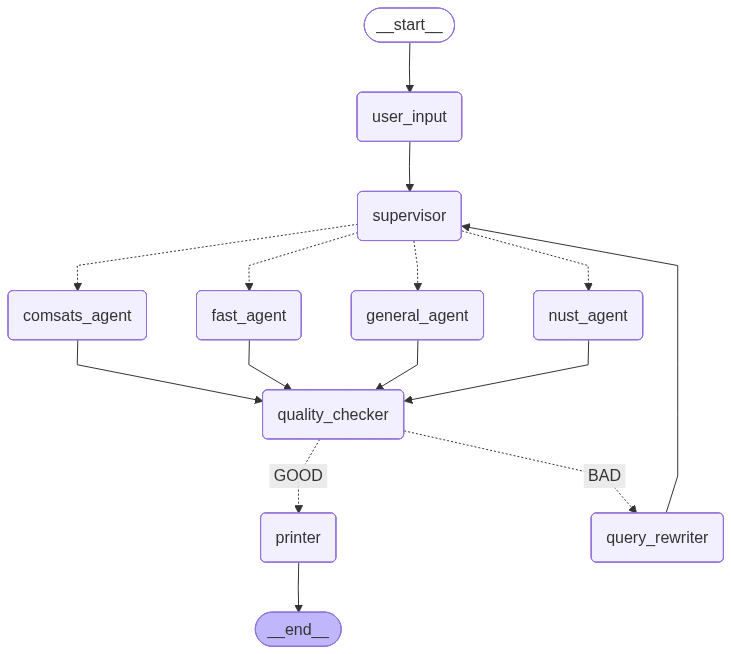

In [31]:
graph = StateGraph(State)

# Add nodes
graph.add_node("user_input", user_input_node)
graph.add_node("supervisor", supervisor_node)
graph.add_node("nust_agent", nust_agent)
graph.add_node("comsats_agent", comsats_agent)
graph.add_node("fast_agent", fast_agent)
graph.add_node("general_agent", general_agent)
graph.add_node("quality_checker", quality_checker_node)
graph.add_node("query_rewriter", query_rewriter_node)
graph.add_node("printer", printer_node)

# Set entry point
graph.set_entry_point("user_input")

# Workflow sequence: user_input → supervisor
graph.add_edge("user_input", "supervisor")

# Supervisor routes to sub-agents
graph.add_conditional_edges(
    "supervisor",
    route_supervisor,
    {
        "nust_agent": "nust_agent",
        "comsats_agent": "comsats_agent",
        "fast_agent": "fast_agent",
        "general_agent": "general_agent"
    }
)


# Sub-agent → quality checker (pass both user query and agent result)
graph.add_edge("nust_agent", "quality_checker")
graph.add_edge("comsats_agent", "quality_checker")
graph.add_edge("fast_agent", "quality_checker")
graph.add_edge("general_agent", "quality_checker")

# Quality checker routing
graph.add_conditional_edges(
    "quality_checker",
    lambda state: "GOOD" if state.get("quality_passed") else "BAD",
    {
        "GOOD": "printer",
        "BAD": "query_rewriter"
    }
)

# After query rewriter, go back to supervisor
graph.add_edge("query_rewriter", "supervisor")

# Printer → END
graph.add_edge("printer", END)

# Compile workflow
workflow = graph.compile()

# Display workflow graph
try: 
    display(Image(workflow.get_graph(xray=True).draw_mermaid_png()))
except:
    print("[INFO] Could not display graph visualization")


In [32]:

if __name__ == "__main__":
    print("="*60)
    print("🎓 Multi-University RAG System with Memory")
    print("="*60)
    print("\nSupported Universities: NUST, COMSATS, FAST")
    print("Type 'quit' to exit, 'clear' to reset conversation")
    print("-"*60)

    # Initialize persistent state
    persistent_state = {
        "conversation_history": [],
        "university_name": "comsats"
    }

    while True:
        query = input("\n❓ Ask your question: ").strip()
        
        if query.lower() == 'quit':
            print("\n👋 Goodbye!")
            break
        
        if query.lower() == 'clear':
            persistent_state = {
                "conversation_history": [],
                "university_name": ""
            }
            print("\n🔄 Conversation history cleared!")
            continue
        
        if not query:
            continue

        try:
            # Merge user query with persistent state
            input_state = {
                **persistent_state,
                "user_query": query
            }
            
            result = workflow.invoke(input_state)
            
            # Update persistent state with results
            persistent_state["conversation_history"] = result.get("conversation_history", [])
            persistent_state["university_name"] = result.get("university_name", "")
            
            # print("\n" + "="*60)
            # print(f"💬 Answer (from {result.get('university_name', 'Unknown')})")
            # print("="*60)
            # print(result["answer"])
            # print("="*60)
            # print(f"state of langgraph is:")
            # for key,value in result.items():
                # print(f"key: {key}-----value:{value}\n")
            # print(f"\n📊 Conversation length: {len(persistent_state['conversation_history'])} exchanges")
            
        except Exception as e:
            print(f"\n❌ Error occurred: {str(e)}")
            import traceback
            traceback.print_exc()

🎓 Multi-University RAG System with Memory

Supported Universities: NUST, COMSATS, FAST
Type 'quit' to exit, 'clear' to reset conversation
------------------------------------------------------------

[USER INPUT NODE] Received new query.
[SUPERVISOR] Routed to: FAST agent
uni name is : FAST 

 Generating answer...

[FAST AGENT] Processing query: who is the rector of fast
[QUALITY CHECKER NODE] Evaluating answer quality...
Answer passed quality check.

✅ FINAL ANSWER (FAST)
The Rector of FAST University (FAST-NUCES) is Dr. Aftab Ahmad Maroof. He has over 40 years of academic leadership experience.


[USER INPUT NODE] Received new query.
[SUPERVISOR] Routed to: NUST agent
uni name is : NUST 

 Generating answer...

[NUST AGENT] Processing query: who is the rector of nust
[QUALITY CHECKER NODE] Evaluating answer quality...
Answer passed quality check.

✅ FINAL ANSWER (NUST)
The current Rector of NUST is Lt. Gen. (R) Engineer Javed Mahmood Bukhari, HI(M).


[USER INPUT NODE] Received new q